In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
%matplotlib inline

# Impedance Spectroscopy Notebook
##### James Amidei, Zach Stedman, Max Markgraf
--------------------------------------------

In this experiment, we tested two "systems under test" (i.e. s.u.t.). Or initial s.u.t was a circuit composed of a resistor and capacitor in series, together in parallel with another resistor. Our second was a russet potato. 

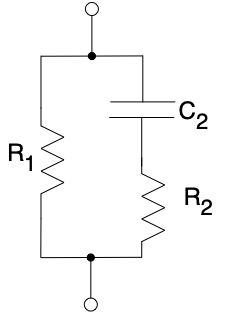
(figure 1. Schematic of the inital s.u.t. used in this experiment.)

$$ Z_{tot} = R_1 + \biggr( \frac{1}{R_2} + \frac{1}{j \omega C_2} \biggr)^{-1} = R_1 + \frac{j \omega C_2 R_2}{j \omega C_2 + R_2}$$

$$\frac{Z}{R_1} = \frac{1+j\frac{\omega}{\omega_c}\frac{1}{1+\frac{R_1}{R_2}}}{1+j\frac{\omega}{\omega_c}} = \frac{\left[1+\left(\frac{\omega}{\omega_c}\right)^2\frac{1}{1+\frac{R_1}{R_2}}\right]-j\left[\frac{\omega}{\omega_c}\frac{\frac{R1}{R2}}{1+\frac{R1}{R2}}\right]}{1+\left(\frac{\omega}{\omega_c}\right)^2}$$

(Equation for the impedance of the circuit s.u.t in natural units. This is derived by adding the impedance of $C_2$ and the resistance of $R_2$ in series, and then adding the resistance of $R_1$ in parallel.)

To simplify the equation above, we took a note from the "NonlinearLeastSquaresFitImpedanceModel" file posted to canvas as defined both $\tau = \frac{1}{\omega_c}$, $f = \frac{\omega}{2\pi}$, and $r = \frac{R_1}{R_2}$. This gives us the following. 

$$\frac{Z}{R_1}=\frac{1+j2\pi f\tau\frac{1}{1+r}}{1+j2\pi f\tau}$$

$$\frac{|Z|}{R_1} = \sqrt{\frac{1+(2 \pi f\tau)^2\frac{1}{(1+r)^2}}{1+(2 \pi f\tau)^2}}$$

Which gives us the phase value of 

$$\phi = arctan\biggr( -\frac{2 \pi f \tau r}{1+r + (2 \pi f \tau)^2} \biggr) $$

These reworked values give us the benefit of being more computationally stable, since there are fewer multipplications and divisions of potentially very small and very larger numbers, as well as returns a normalized value of the impedance. This normalized value is independent of scale while preserving the behavior of the system, and thus makes it easier to see if any intrinsic characteristics arise in the math. In particular, we'll try to pay attention to the constants $\tau$ and $r$. 

### Calculated values 

This is what we would expect to see given the expected values of our components. These are our initial calculation 

r_guess = 10.0  tau_guess = 4.547e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 200.0 ohms    R2_fit = 20.7 ohms   C_2_fit = 2.245e-07 F


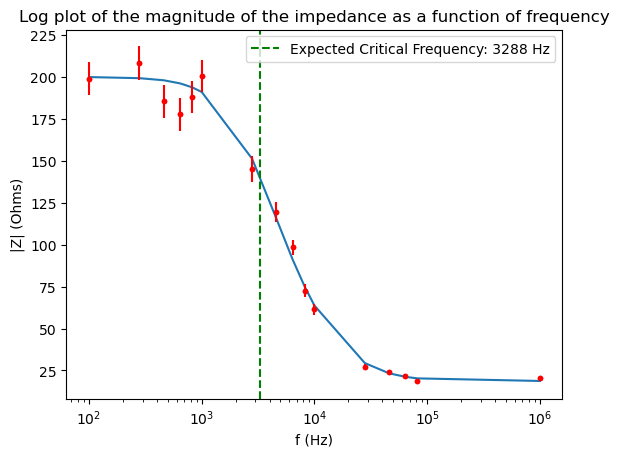

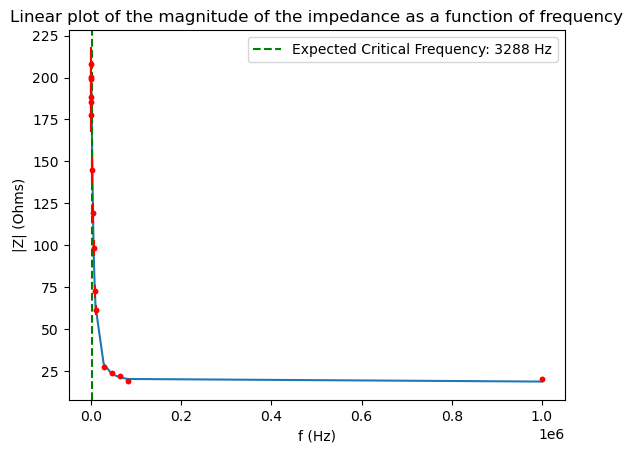

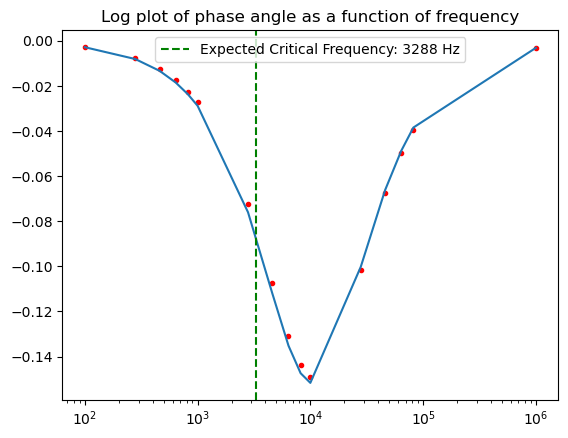

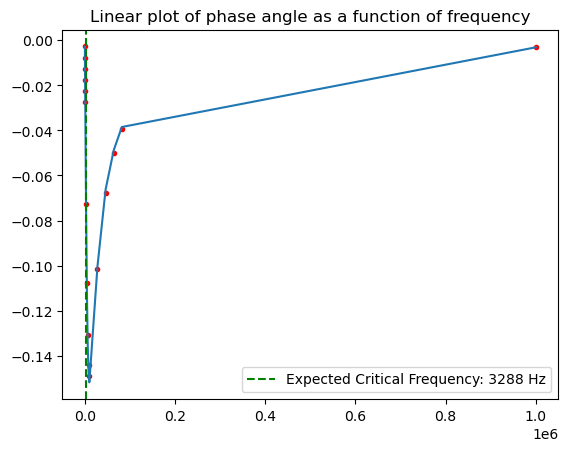

In [2]:
# These frequency values were chosen because they give us 5 even steps per decade. 
f = np.array([100, 280, 460, 640, 820, 1000, 2800, 4600, 6400, 8200, 10000, 28000, 46000, 64000, 82000, 1000000]) 

N_data_points = len(f)

def zfunc(ff, rr, tautau): 
    ft2 = (2*np.pi*ff*tautau)**2
    zz = np.sqrt((1+ft2/(1+rr)**2)/(1+ft2))
    return zz

def phifunc(ff, rr, tautau):
    fftt = (2*np.pi*ff*tautau)
    phiphi = np.arctan(-fftt/(1+rr+fftt**2))
    return phiphi

R1 = 200 # Ohms 
R2 = 20 # Ohms
C2 = 0.22e-6 # Farads

omega_c = 1/(C2*(R1+R2)) # critical angular frequency 

f_c = omega_c/(2*np.pi) # critical frequnecy

r = R1/R2
tau = 1/(omega_c)

z_sigma_rel = 0.05 # relative uncertainty in impedance measurement
phase_sigma_rel = 0.2 # degrees

# normalized impedance data (impedance divided by DC resistance R1)
z_exact = zfunc(f, r, tau) 
z_sigma = z_sigma_rel*z_exact
z = np.random.normal(z_exact, z_sigma, N_data_points) # create some random variation

phase_exact = phifunc(f, r, tau)
phase_sigma = phase_sigma_rel*phase_exact
#phase = np.random.normal(phase_exact, phase_sigma, N_data_points)
phase = phase_exact

r_guess = 10. # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3500 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess,tau_guess))

popt, pcov = curve_fit(zfunc,f,z,p0=[r_guess,tau_guess])
r_fit = popt[0]
tau_fit = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1, R1/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit = zfunc(f, r_fit, tau_fit)
phi_fit = phifunc(f, r_fit, tau_fit)

plt.figure(0)
plt.plot(f, z*R1,'r.', f, zfit*R1)
plt.axvline(x=f_c, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c)} Hz')
plt.xscale('log')
plt.errorbar(f, z*R1, yerr=z_sigma*R1, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(f, z*R1,'r.', f, zfit*R1)
plt.axvline(x=f_c, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c)} Hz')
#plt.xscale('log')
plt.errorbar(f, z*R1, yerr=z_sigma*R1, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(f, phase, 'r.', f, phi_fit )
plt.axvline(x=f_c, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(f, phase, 'r.', f, phi_fit )
plt.axvline(x=f_c, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### Collected Data

We performed three runs each with each of the three dominant resistors for each of the s.u.t. Data named "data_R0?_\#" refers to data collect with the circuit used as the s.u.t. and data named "data_R0?p_\#" refers to the data collected with the russet potato as the system under test. The "?" wildcard refers to the dominant resistor (i.e. a, b, or c) and "#" refers to the run number (e.g. 1, 2, or 3). 

The average of the three runs was taken as used in the analysis to describe each setup. We then assign each column as a variable to work with later on in this notebook. 

Note: Data was typed out by hand into .txt files. I got tried of trying to make a loop that ran through the files, so I just decided to do it by hand. Elegant? Absolutely not. Does it work? 

In [3]:
# getting the data from our files
data_R0a_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0a_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0a_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0a_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0a_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0a_Run3.txt', delimiter=',', skip_header=4, dtype=float)
data_R0b_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0b_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0b_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0b_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0b_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_18_24_R0b_Run3.txt', delimiter=',', skip_header=4, dtype=float)
data_R0c_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0c_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0c_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_Run3.txt', delimiter=',', skip_header=4, dtype=float)
data_R0ap_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0a_with_potato_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0ap_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0a_with_potato_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0ap_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0a_with_potato_Run3.txt', delimiter=',', skip_header=4, dtype=float)
data_R0bp_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0b_with_potato_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0bp_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0b_with_potato_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0bp_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0b_with_potato_Run3.txt', delimiter=',', skip_header=4, dtype=float)
data_R0cp_1 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_with_potato_Run1.txt', delimiter=',', skip_header=4, dtype=float)
data_R0cp_2 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_with_potato_Run2.txt', delimiter=',', skip_header=4, dtype=float)
data_R0cp_3 = np.genfromtxt('OrganizedData/ImpedanceSpecData3_21_24_R0c_with_potato_Run3.txt', delimiter=',', skip_header=4, dtype=float)

In [4]:
# averaging data
data_R0a_avg = (data_R0a_1 + data_R0a_2 + data_R0a_3)/3
data_R0b_avg = (data_R0b_1 + data_R0b_2 + data_R0b_3)/3
data_R0c_avg = (data_R0c_1 + data_R0c_2 + data_R0c_3)/3
data_R0ap_avg = (data_R0ap_1 + data_R0ap_2 + data_R0ap_3)/3
data_R0bp_avg = (data_R0bp_1 + data_R0bp_2 + data_R0bp_3)/3
data_R0cp_avg = (data_R0cp_1 + data_R0cp_2 + data_R0cp_3)/3

# defining variable from data 
freq_a = data_R0a_avg[:,0]
sigma_freq_a = data_R0a_avg[:,1]
freq_b = data_R0b_avg[:,0]
sigma_freq_b = data_R0b_avg[:,1]
freq_c = data_R0c_avg[:,0]
sigma_freq_c = data_R0c_avg[:,1]
freq_ap = data_R0ap_avg[:,0]
sigma_freq_ap = data_R0ap_avg[:,1]
freq_bp = data_R0bp_avg[:,0]
sigma_freq_bp = data_R0bp_avg[:,1]
freq_cp = data_R0cp_avg[:,0]
sigma_freq_cp = data_R0cp_avg[:,1]

voltage_a = data_R0a_avg[:,2]
sigma_voltage_a = data_R0a_avg[:,3]
voltage_b = data_R0b_avg[:,2]
sigma_voltage_b = data_R0b_avg[:,3]
voltage_c = data_R0c_avg[:,2]
sigma_voltage_c = data_R0c_avg[:,3]
voltage_ap = data_R0ap_avg[:,2]
sigma_voltage_ap = data_R0ap_avg[:,3]
voltage_bp = data_R0bp_avg[:,2]
sigma_voltage_bp = data_R0bp_avg[:,3]
voltage_cp = data_R0cp_avg[:,2]
sigma_voltage_cp = data_R0cp_avg[:,3]

phase_a = data_R0a_avg[:,4]
sigma_phase_a = data_R0a_avg[:,5]
phase_b = data_R0b_avg[:,4]
sigma_phase_b = data_R0b_avg[:,5]
phase_c = data_R0c_avg[:,4]
sigma_phase_c = data_R0c_avg[:,5]
phase_ap = data_R0ap_avg[:,4]
sigma_phase_ap = data_R0ap_avg[:,5]
phase_bp = data_R0bp_avg[:,4]
sigma_phase_bp = data_R0bp_avg[:,5]
phase_cp = data_R0cp_avg[:,4]
sigma_phase_cp = data_R0cp_avg[:,5]

### Analysis with collected data 

This is what we see from our actaully measured data. Each component in the ciruit s.u.t. was measured using a LCR multimeter before performing any runs. These's values and their errors are what's used here. 

##### Error propagation 
---------

$$ \sigma_c = \sigma_a + \sigma_b \hspace{0.5cm} \text{ for addition and subtraction}$$
$$ \sigma_c = \sum^{N}_{i} \biggr( \sigma_i \frac{\partial C}{\partial x_i} \biggr)^2 \hspace{0.5cm} \text{ for multiplication and division}$$

$$ \omega_c = \frac{1}{C_2(R_1 +R_1)}$$

$$ \frac{\partial \omega_c}{\partial C_2} = -\frac{1}{C^2_2(R_1 + R_2)} \hspace{0.5cm} \frac{\partial = \omega_c}{\partial R_1} -\frac{1}{C_2(R_1 + R_2)^2}\hspace{0.5cm} \frac{\partial \omega_c}{\partial R_2} = -\frac{1}{C_2(R_1 + R_2)^2}$$

$$ r = \frac{R_1}{R_2}$$

$$ \frac{\partial r}{\partial R_1} = \frac{1}{R_2} \hspace{0.5cm} \frac{\partial r}{\partial R_2} = -\frac{R_1}{R_2^2} $$

$$ \tau = C_2 (R_1 + R_2)$$


$$\frac{|Z|}{R_1} = \sqrt{\frac{1+(2 \pi f\tau)^2\frac{1}{(1+r)^2}}{1+(2 \pi f\tau)^2}}$$

$$ \frac{1}{R_1} \frac{\partial |Z|}{\partial f} = \frac{2^2 \pi^2 f \tau^2}{(r + 1)^2 \sqrt{(2 \pi f \tau)^2 + 1}\sqrt{ \frac{(2 \pi f \tau)^2}{(r+1)^2} +1 }} - \frac{2^2 \pi^2 f \tau^2 \sqrt{ \frac{(2 \pi f \tau)^2}{(r+1)^2} + 1 }}{((2 \pi f \tau)^2 + 1)^{3/2}}  $$

$$ \frac{1}{R_1} \frac{\partial |Z|}{\partial \tau} = \frac{2^2 \pi^2 f^2 \tau}{(r + 1)^2 \sqrt{(2 \pi f \tau)^2 + 1}\sqrt{ \frac{(2 \pi f \tau)^2}{(r+1)^2} + 1 }} - \frac{2^2 \pi^2 f^2 \tau \sqrt{ \frac{(2 \pi f \tau)^2}{(r+1)^2} + 1 }}{((2 \pi f \tau)^2 + 1)^{3/2}}  $$

$$ \frac{1}{R_1} \frac{\partial |Z|}{\partial r} = - \frac{(2 \pi f \tau)^2}{(r + 1)^3 \sqrt{(2 \pi f \tau)^2 + 1}\sqrt{ \frac{(2 \pi f \tau)^2}{(r+1)^2} + 1 }} $$



In [5]:
R1_real = 197.4 # Ohms
sigma_R1_real = 0.1 # Ohms

R2_real = 19.7 # Ohms
sigma_R2_real = 0.1 # Ohms

C2_real = 0.239e-6 # Farads
sigma_C2_real = 0.0005e-6 # Farads

omega_c_real = 1/(C2_real*(R1_real + R2_real))
del_o_del_c = -1/((R1_real+R2_real)*C2_real**2)
del_o_del_r1 = -1/(C2_real*(R1_real+R2_real)**2)
del_o_del_r2 = -1/(C2_real*(R1_real+R2_real)**2)
sigma_omega_c_real = np.sqrt((sigma_C2_real*del_o_del_c)**2 + (sigma_R1_real*del_o_del_r1)**2 + (sigma_R2_real*del_o_del_r2)**2)

f_c_real = omega_c_real/(2*np.pi)
sigma_f_c_real = sigma_omega_c_real/(2*np.pi)

tau_real = 1/omega_c_real

sigma_tau_real = np.sqrt( (sigma_C2_real*(R1_real+R2_real))**2 + ((sigma_R1_real**2 + sigma_R2_real**2)*C2_real)**2 )

r_real = R1_real/R2_real
del_r_del_r1 = 1/R2_real
del_r_del_r2 = -R1_real/R2_real**2
sigma_r_real = np.sqrt((sigma_R1_real*del_r_del_r1)**2 + (sigma_R2_real*del_r_del_r2)**2)

print(f'f_c_real = {f_c_real:.2f} +/- {sigma_f_c_real:.2f}')
print()
print(f'r_real = {r_real:.2f} +/- {sigma_r_real:.2f}')


f_c_real = 3067.34 +/- 6.72

r_real = 10.02 +/- 0.05


### R0a

In [6]:
# calculation for error of the impedance

alpha = 2*np.pi*freq_a*tau_real
rho = r+1

del_z_del_fa = ((freq_a*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_a*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_a)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_a)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_a = np.sqrt((sigma_freq_a*del_z_del_fa)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


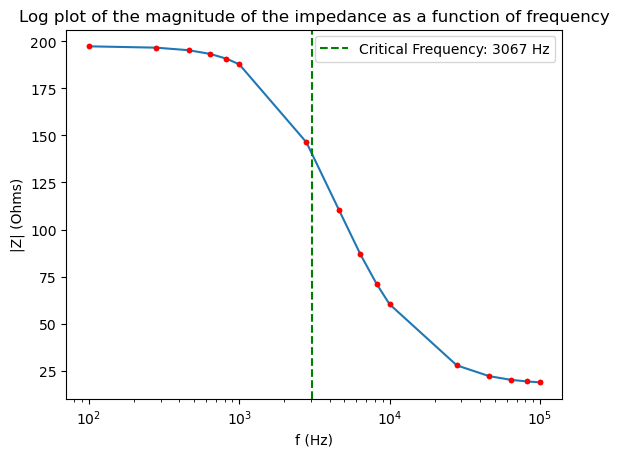

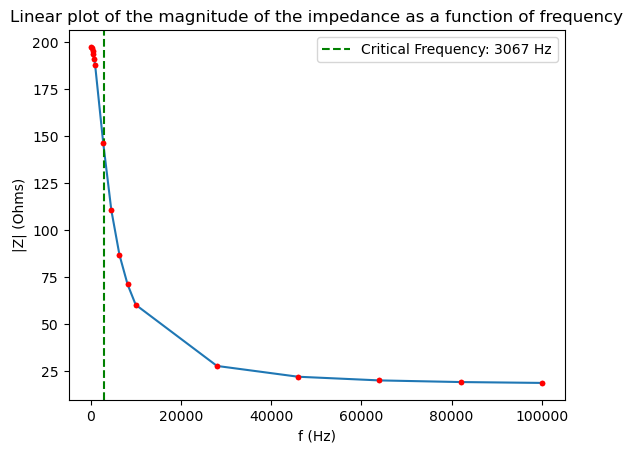

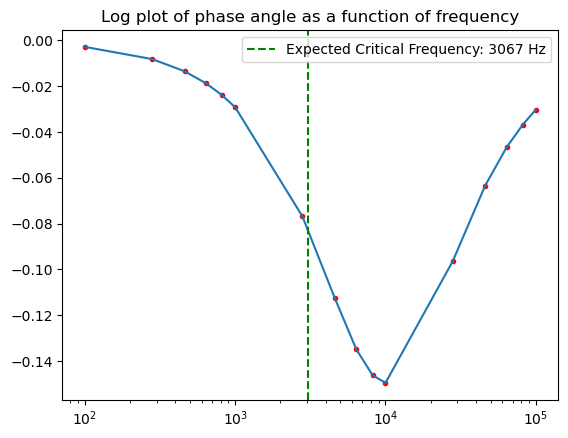

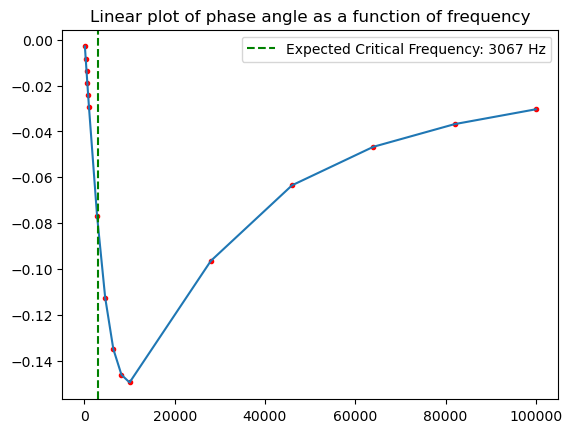

In [7]:
z_exact_a = zfunc(freq_a, r_real, tau_real) 
z_a = z_exact_a

phase_exact_a = phifunc(freq_a, r_real, tau_real)
phase_a = phase_exact_a

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_a, z_exact_a, p0=[r_guess,tau_guess])
r_fit_a = popt[0]
tau_fit_a = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_a = zfunc(freq_a, r_fit_a, tau_fit_a)
phi_fit_a = phifunc(freq_a, r_fit_a, tau_fit_a)

plt.figure(0)
plt.plot(freq_a, z_a*R1_real,'r.', freq_a, zfit_a*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_a, z_a*R1_real, yerr=sigma_z_a, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_a, z_a*R1_real,'r.', freq_a, zfit_a*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_a, z_a*R1_real, yerr=sigma_z_a, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_a, phase_a, 'r.', freq_a, phi_fit_a )
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_a, phase_a, 'r.', freq_a, phi_fit_a )
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### R0b

In [8]:
alpha = 2*np.pi*freq_b*tau_real
rho = r+1

del_z_del_fb = ((freq_b*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_b*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_b)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_b)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_b = np.sqrt((sigma_freq_b*del_z_del_fa)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


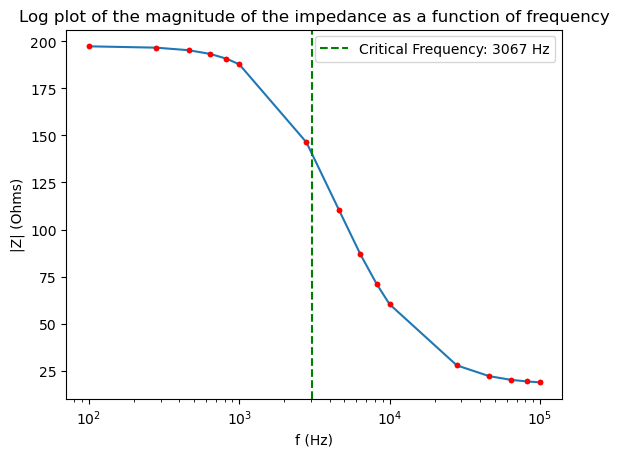

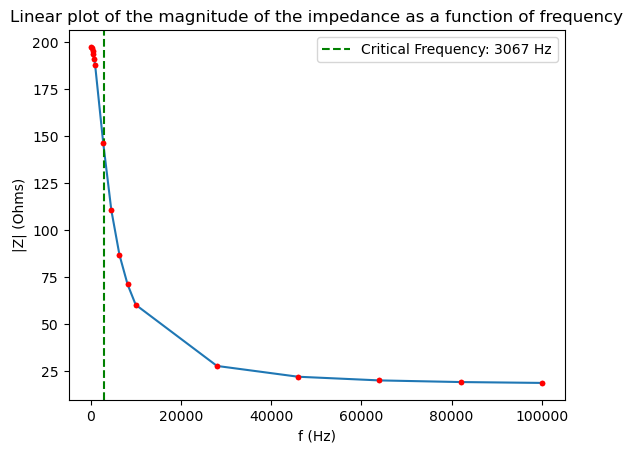

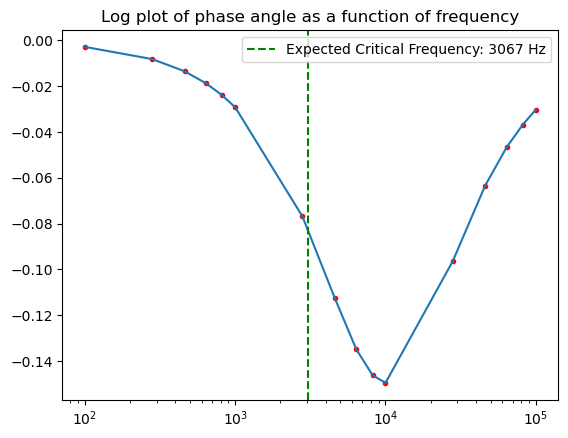

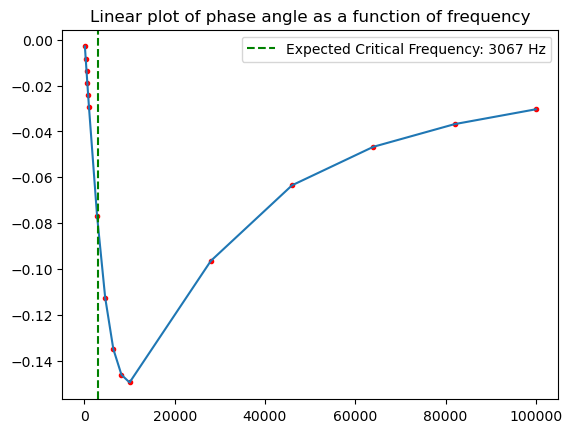

In [9]:
z_exact_b = zfunc(freq_b, r_real, tau_real) 
z_b = z_exact_b

phase_exact_b = phifunc(freq_b, r_real, tau_real)
phase_b = phase_exact_b

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_b, z_exact_b, p0=[r_guess,tau_guess])
r_fit_b = popt[0]
tau_fit_b = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_b = zfunc(freq_b, r_fit_b, tau_fit_b)
phi_fit_b = phifunc(freq_b, r_fit_b, tau_fit_b)

plt.figure(0)
plt.plot(freq_b, z_b*R1_real,'r.', freq_b, zfit_b*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_b, z_b*R1_real, yerr=sigma_z_b, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_b, z_b*R1_real,'r.', freq_b, zfit_b*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_b, z_b*R1_real, yerr=sigma_z_b, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_b, phase_b, 'r.', freq_b, phi_fit_b)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_b, phase_b, 'r.', freq_b, phi_fit_b)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### R0c

In [10]:
alpha = 2*np.pi*freq_c*tau_real
rho = r+1

del_z_del_fb = ((freq_c*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_c*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_c)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_c)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_c = np.sqrt((sigma_freq_c*del_z_del_fa)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


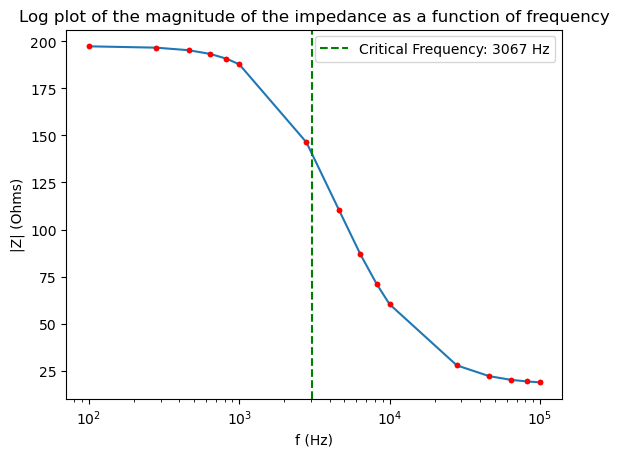

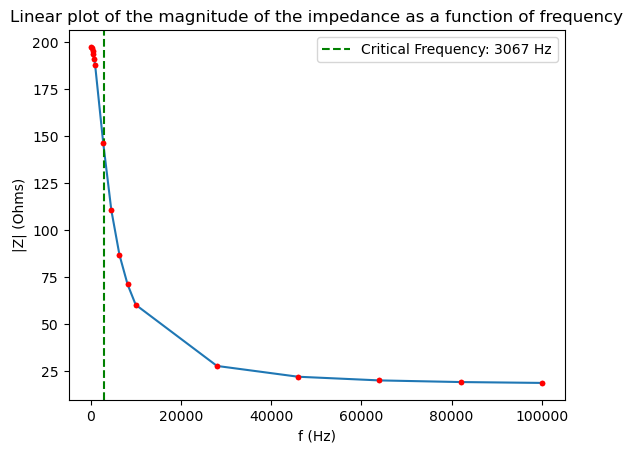

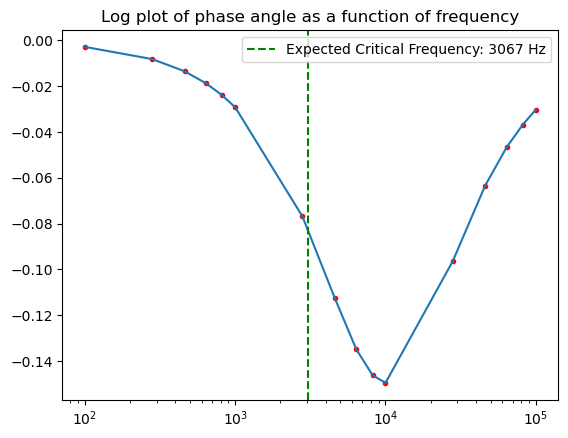

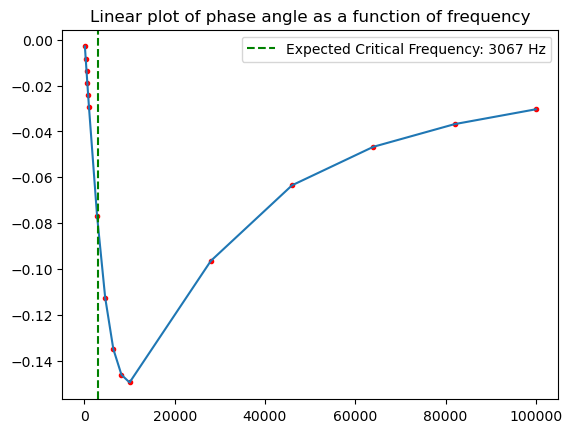

In [11]:
z_exact_c = zfunc(freq_c, r_real, tau_real) 
z_c = z_exact_c

phase_exact_c = phifunc(freq_c, r_real, tau_real)
phase_c = phase_exact_c

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_c, z_exact_c, p0=[r_guess,tau_guess])
r_fit_c = popt[0]
tau_fit_c = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_c = zfunc(freq_c, r_fit_b, tau_fit_b)
phi_fit_c = phifunc(freq_c, r_fit_c, tau_fit_c)

plt.figure(0)
plt.plot(freq_c, z_c*R1_real,'r.', freq_c, zfit_c*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_c, z_c*R1_real, yerr=sigma_z_c, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_c, z_c*R1_real,'r.', freq_c, zfit_c*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_c, z_c*R1_real, yerr=sigma_z_c, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_c, phase_c, 'r.', freq_c, phi_fit_c)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_c, phase_c, 'r.', freq_c, phi_fit_c)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### R0a with potato

In [12]:
alpha = 2*np.pi*freq_ap*tau_real
rho = r+1

del_z_del_fap = ((freq_ap*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_ap*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_ap)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_ap)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_ap = np.sqrt((sigma_freq_ap*del_z_del_fap)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


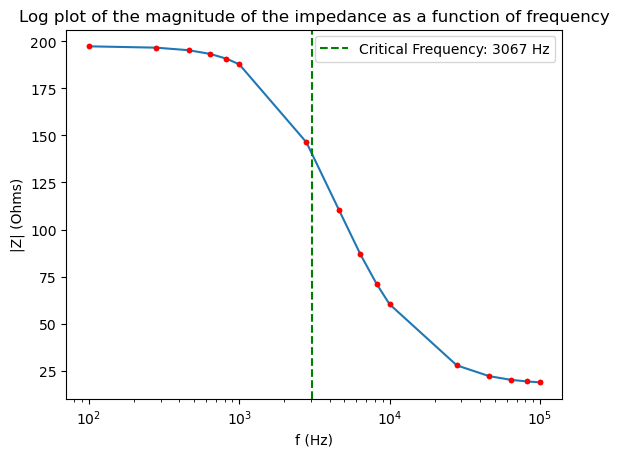

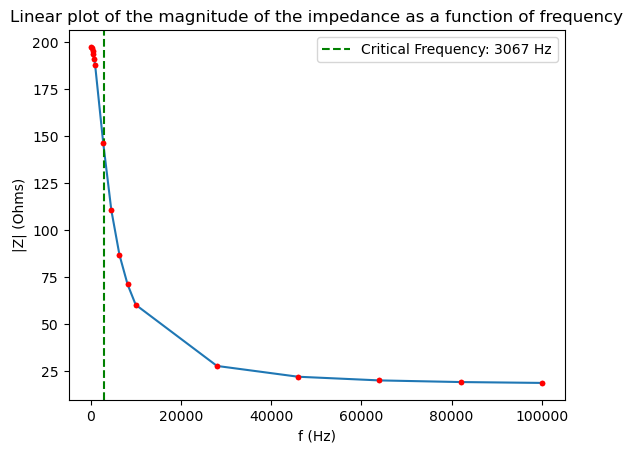

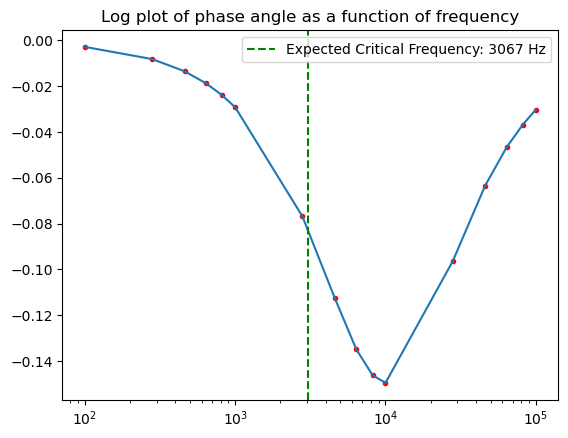

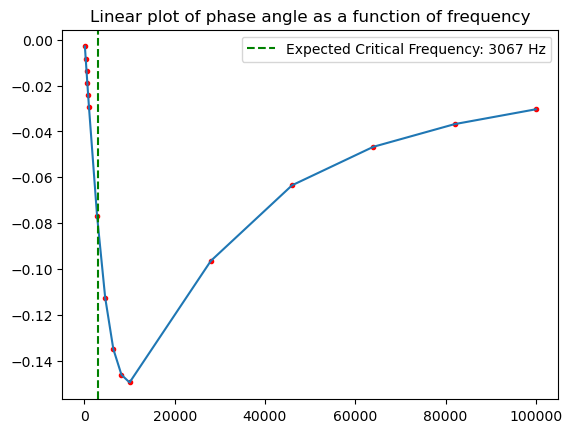

In [13]:
z_exact_ap = zfunc(freq_ap, r_real, tau_real) 
z_ap = z_exact_ap

phase_exact_ap = phifunc(freq_ap, r_real, tau_real)
phase_ap = phase_exact_ap

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_ap, z_exact_ap, p0=[r_guess,tau_guess])
r_fit_ap = popt[0]
tau_fit_ap = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_ap = zfunc(freq_ap, r_fit_ap, tau_fit_ap)
phi_fit_ap = phifunc(freq_ap, r_fit_ap, tau_fit_ap)

plt.figure(0)
plt.plot(freq_ap, z_ap*R1_real,'r.', freq_ap, zfit_ap*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_ap, z_ap*R1_real, yerr=sigma_z_ap, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_ap, z_ap*R1_real,'r.', freq_ap, zfit_ap*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_ap, z_ap*R1_real, yerr=sigma_z_ap, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_ap, phase_ap, 'r.', freq_ap, phi_fit_ap)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_ap, phase_ap, 'r.', freq_ap, phi_fit_ap)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### R0b with potato

In [14]:
alpha = 2*np.pi*freq_bp*tau_real
rho = r+1

del_z_del_fbp = ((freq_bp*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_bp*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_bp)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_bp)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_bp = np.sqrt((sigma_freq_bp*del_z_del_fap)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


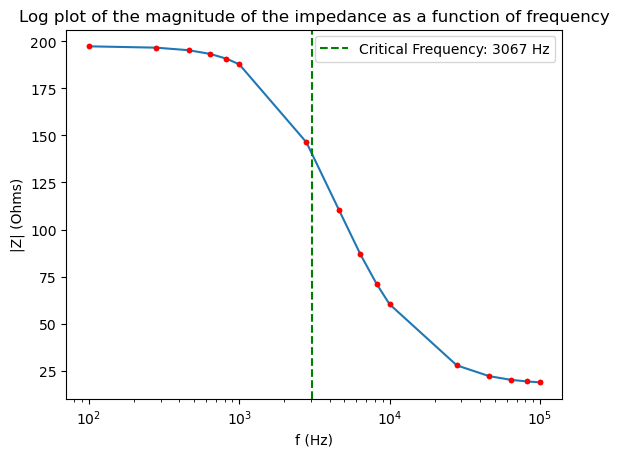

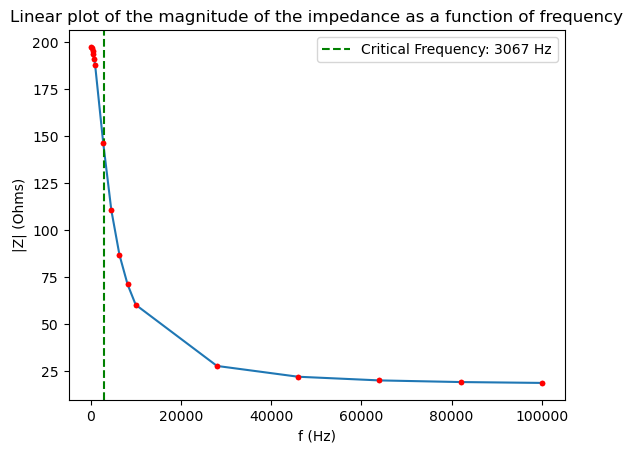

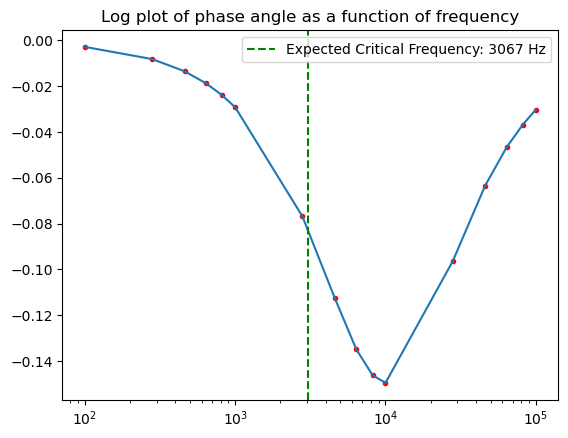

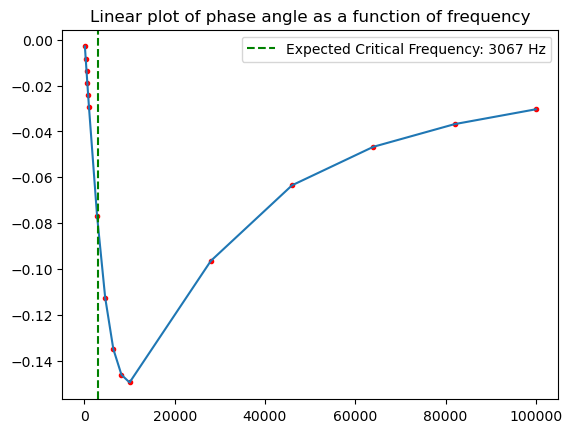

In [15]:
z_exact_bp = zfunc(freq_bp, r_real, tau_real) 
z_bp = z_exact_bp

phase_exact_bp = phifunc(freq_bp, r_real, tau_real)
phase_bp = phase_exact_bp

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_bp, z_exact_bp, p0=[r_guess, tau_guess])
r_fit_bp = popt[0]
tau_fit_bp = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_bp = zfunc(freq_bp, r_fit_bp, tau_fit_bp)
phi_fit_bp = phifunc(freq_bp, r_fit_bp, tau_fit_bp)

plt.figure(0)
plt.plot(freq_bp, z_bp*R1_real,'r.', freq_bp, zfit_bp*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_bp, z_bp*R1_real, yerr=sigma_z_bp, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_bp, z_bp*R1_real,'r.', freq_bp, zfit_bp*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_bp, z_bp*R1_real, yerr=sigma_z_bp, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_bp, phase_bp, 'r.', freq_bp, phi_fit_bp)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_bp, phase_bp, 'r.', freq_bp, phi_fit_bp)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

### R0c with potato 

In [16]:
alpha = 2*np.pi*freq_cp*tau_real
rho = r+1

del_z_del_fcp = ((freq_cp*(2*np.pi*tau_real)**2)/((rho**2) * np.sqrt((alpha**2) + 1) * np.sqrt((alpha**2)/(rho**2) + 1))) - ((freq_cp*((2*np.pi*tau_real)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_tau = ((tau_real*(2*np.pi*freq_cp)**2)/( (rho**2)*np.sqrt((alpha**2)+1)*np.sqrt(((alpha**2)/(rho**2)) + 1) )) - ((tau_real*((2*np.pi*freq_cp)**2)*np.sqrt(((alpha**2)/(rho**2)) + 1))/((alpha**2 + 1)**(3/2)))
del_z_del_r = - ((alpha**2)/((rho**3)*np.sqrt(alpha**2 + 1)*np.sqrt((alpha**2)/(rho**2) + 1)))

# Note: This value of the error for the impedance alreay assumes the R1 has been divided out. 
# So there is no need to multiply it back in later. 
# This would result in massively overblown error bars. 
sigma_z_cp = np.sqrt((sigma_freq_cp*del_z_del_fap)**2 + (sigma_tau_real*del_z_del_tau)**2 + (sigma_r_real*del_z_del_r)**2)

r_guess = 10.0  tau_guess = 5.305e-05 s
r_fit = 9.678  tau_fit = 4.955e-05 s   f_c_fit = 3.212e+03 Hz
R1 = 197.4 ohms    R2_fit = 20.4 ohms   C_2_fit = 2.245e-07 F


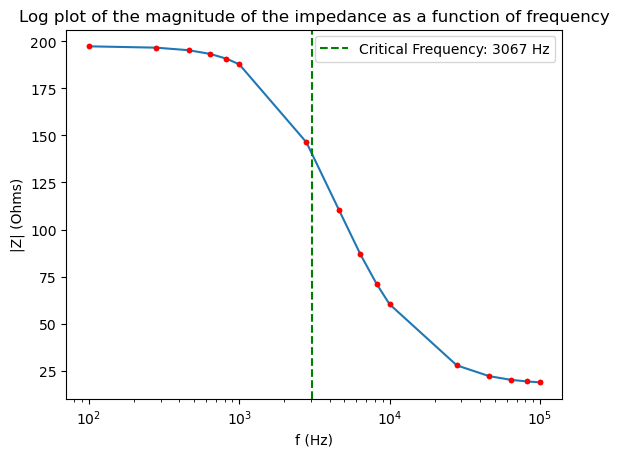

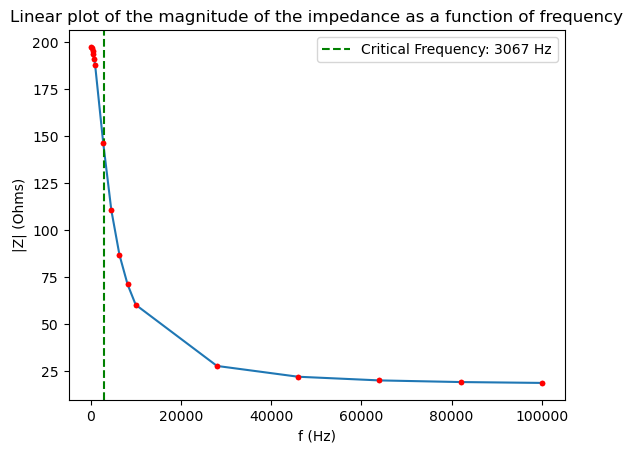

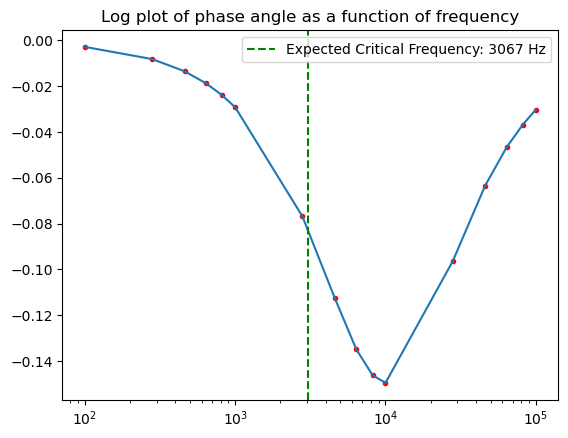

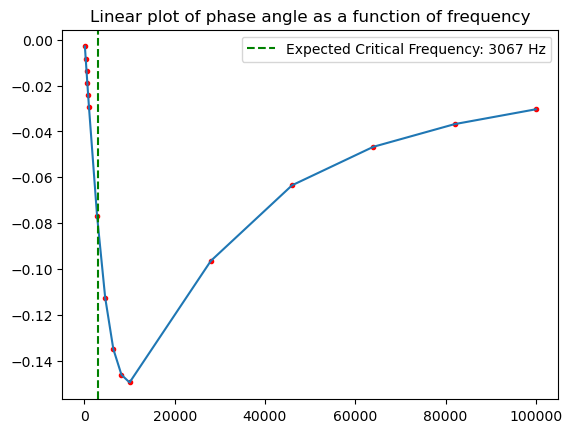

In [17]:
z_exact_cp = zfunc(freq_cp, r_real, tau_real) 
z_cp = z_exact_cp

phase_exact_cp = phifunc(freq_cp, r_real, tau_real)
phase_cp = phase_exact_cp

r_guess = 10.0 # guess of ratio of DC resistance R1 to capacitive path resistance R2
f_c_guess = 3000 # guess of critical frequency in Hz
tau_guess = 1/(2*np.pi*f_c_guess)

print('r_guess = {0:.1f}  tau_guess = {1:.3e} s'.format(r_guess, tau_guess))

popt, pcov = curve_fit(zfunc, freq_cp, z_exact_cp, p0=[r_guess, tau_guess])
r_fit_cp = popt[0]
tau_fit_cp = popt[1]

print('r_fit = {0:.3f}  tau_fit = {1:.3e} s   f_c_fit = {2:.3e} Hz'
      .format(r_fit, tau_fit,1/(2*np.pi*tau_fit)))

print('R1 = {0:.1f} ohms    R2_fit = {1:.1f} ohms   C_2_fit = {2:.3e} F'
      .format(R1_real, R1_real/r_fit, tau_fit/(R1*(1+1/r_fit))))

zfit_cp = zfunc(freq_cp, r_fit_cp, tau_fit_cp)
phi_fit_cp = phifunc(freq_cp, r_fit_cp, tau_fit_cp)

plt.figure(0)
plt.plot(freq_cp, z_cp*R1_real,'r.', freq_cp, zfit_cp*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.errorbar(freq_cp, z_cp*R1_real, yerr=sigma_z_cp, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Log plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(1)
plt.plot(freq_cp, z_cp*R1_real,'r.', freq_cp, zfit_cp*R1_real)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.errorbar(freq_cp, z_cp*R1_real, yerr=sigma_z_cp, fmt='r.')
plt.xlabel('f (Hz)')
plt.ylabel('|Z| (Ohms)')
plt.title('Linear plot of the magnitude of the impedance as a function of frequency')
plt.legend()

plt.figure(2)
plt.plot(freq_cp, phase_cp, 'r.', freq_cp, phi_fit_cp)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
plt.xscale('log')
plt.title('Log plot of phase angle as a function of frequency')
plt.legend()

plt.figure(3)
plt.plot(freq_cp, phase_cp, 'r.', freq_cp, phi_fit_cp)
plt.axvline(x=f_c_real, color='g', linestyle='--', label=f'Expected Critical Frequency: {round(f_c_real)} Hz')
#plt.xscale('log')
plt.title('Linear plot of phase angle as a function of frequency')
plt.legend()

plt.show()

Continue analysis with the constants $\tau$ and $r$. 